<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025_Lab2-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uczenie Głębokie z Sieciami Neuronowymi

## Sprawozdanie nr 1

## Jan Banot
### 02.11.2025

# Zad 1.

Wyobraź sobie, że budujesz system monitorowania dla zakładu produkcyjnego. Czujniki zbierają dane, aby określić, czy maszyna działa prawidłowo, czy też wystąpiła awaria. Chociaż rzeczywiste dane z czujników są złożone, zasymulujemy je za pomocą syntetycznego zbioru danych "two-moons", który zawiera klasy nierozdzielne liniowo.

Twoim zadaniem jest zbudowanie wielowarstwowej sieci typu MLP do klasyfikacji wyników pomiarów.

Wskazówki:
- Zbuduj wielowarstwowy perceptron (MLP) z co najmniej dwiema warstwami ukrytymi.  
- Podziel dane na zbiór testowy oraz treningowy
- Wytrenuj model, używając odpowiedniej do problemu funckji straty.  

Szablon rozwiązania podany jest poniżej.

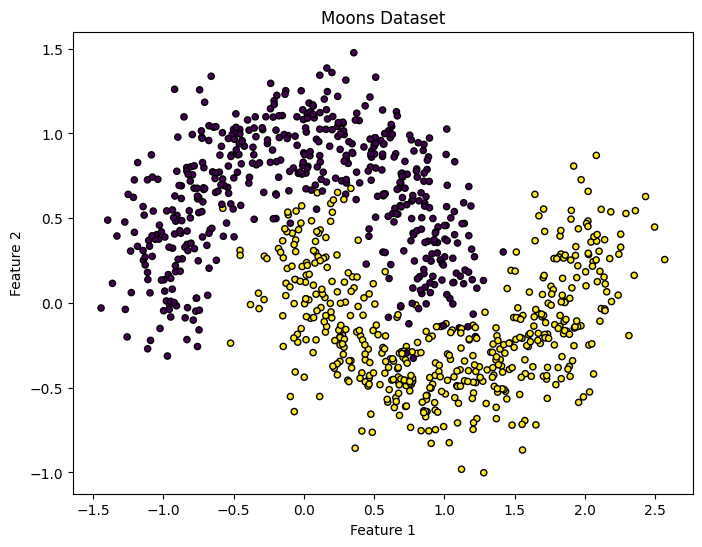

MLP(
  (hidden1): Linear(in_features=2, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch [10/100], Loss: 0.5569
Epoch [20/100], Loss: 0.4275
Epoch [30/100], Loss: 0.3327
Epoch [40/100], Loss: 0.2938
Epoch [50/100], Loss: 0.2754
Epoch [60/100], Loss: 0.2501
Epoch [70/100], Loss: 0.2233
Epoch [80/100], Loss: 0.1868
Epoch [90/100], Loss: 0.1516
Epoch [100/100], Loss: 0.1233
Test Accuracy: 0.9750


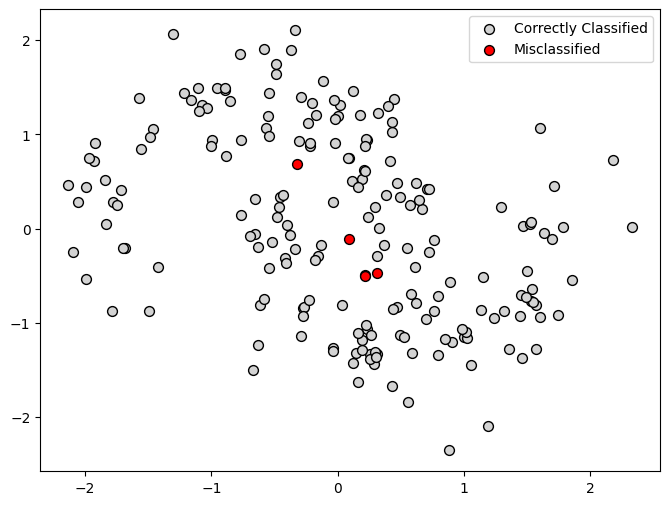

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fikcyjne dane pomiarowe
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Wykres
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20, edgecolor='k')
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TODO: podział danych na zb. treningowy oraz testowy
# 80% trening, 20% testy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Konwersja do tensorów PyTorch
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# .FloatTensor() dla etykiet, ponieważ funkcja straty BCELoss tego oczekuje
# .view(-1, 1) zmienia kształt z [800] na [800, 1], aby pasował do wyjścia sieci
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # TODO: Warstwy sieci
        # Warstwa 1: 2 wejścia (cechy), 16 wyjść (neuronów)
        self.hidden1 = nn.Linear(2, 16)
        # Warstwa 2: 16 wejść, 8 wyjść
        self.hidden2 = nn.Linear(16, 8)
        # Warstwa wyjściowa: 8 wejść, 1 wyjście
        self.output = nn.Linear(8, 1)

        # Funkcje aktywacji
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO: Obliczenia fazy "w przód"
        # Przepływ: warstwa1 -> relu -> warstwa2 -> relu -> wyjście -> sigmoid
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

model = MLP()
print(model)

# Definicja funkcji straty
criterion = nn.BCELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trening
for epoch in range(100):
    # TODO
    # 0. Ustawiamy model w tryb treningu
    model.train()

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Loss function
    loss = criterion(y_pred, y_train)

    # 3. Zero Grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Weights update
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")


# Ewaluacja modelu
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")


# Wykres poprawnie / niepoprawnie sklasyfikowanych punktów danych
with torch.no_grad():
    correct_idx = (y_pred_class == y_test).view(-1).numpy()
    misclassified_idx = (y_pred_class != y_test).view(-1).numpy()
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy().flatten()

plt.figure(figsize=(8, 6))
# Poprawna klasyfikacja -- kolor szary
plt.scatter(X_test_np[correct_idx, 0], X_test_np[correct_idx, 1],
            c='lightgray', label='Correctly Classified', s=50, edgecolor='k')
# Błędna -- kolor czerwony
plt.scatter(X_test_np[misclassified_idx, 0], X_test_np[misclassified_idx, 1],
            c='red', label='Misclassified', s=50, edgecolor='k')
plt.legend()
plt.show()

# Zad. 2.

Opracuj model prognozujący liczbę dziennych wypożyczeń rowerów w systemie Capital Bikeshare (Waszyngton, D.C.) na podstawie danych historycznych zawartych w zbiorze "Daily Bike Rentals" z UCI Machine Learning Repository. Wartość docelowa to liczba wypożyczeń rowerów na dzień (kolumna **cnt**), która jest nieujemną liczbą całkowitą i podąża za rozkładem [rozkładem Poissona](https://pl.wikipedia.org/wiki/Rozk%C5%82ad_Poissona)

Zbiór danych zawiera 731 dziennych obserwacji z cechami takimi jak: temperatura (**temp**), wilgotność (**hum**), prędkość wiatru (**windspeed**), pora roku (**season**), warunki pogodowe (**weathersit**) oraz zmienne związane z datą (np. **yr**, **mnth**, **weekday**).


Wskazówki:

* Zaimplementuj funkcję straty:
$$L = \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \log(\hat{y}_i) \right)$$
gdzie:
$\hat{y}_i$ jest wart. predykowaną a $y_i$ prawdziwą.

* Zastosuj sieć MLP z 2 warstwami ukrytymi

* Ponieważ przewidywane liczby wypożyczeń muszą być nieujemne, należy zastosować funkcję aktywacji **Softplus** w warstwie wyjściowej MLP.

* Jakich zmian należy dokonać, żeby móc zastosować `torch.nn.PoissonNLLLoss` -- zmodyfikuj implementację i sprawdź działanie

## Przygotowanie danych

In [101]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
!wget -O data.zip $url
!unzip -o data.zip # Use -o to overwrite if the directory already exists

# Read the file from the extracted directory
df = pd.read_csv("day.csv")
target = df["cnt"]
features = df.drop(columns=["cnt", "instant", "dteday"])  # Odrzuć ID oraz datę

--2025-11-02 19:09:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.zip’

data.zip                [   <=>              ] 273.43K   448KB/s    in 0.6s    

2025-11-02 19:09:12 (448 KB/s) - ‘data.zip’ saved [279992]

Archive:  data.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [102]:
features

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867
727,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451
728,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182
729,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432


## Szkic rozwiązania

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = features.values
y = target.values

print(f'X shape (before): {X.shape}')
print(f'y shape (before): {y.shape}')

# Podział na zb. treningowy i testowy
# TODO
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacja wartości
# TODO
# scaler tylko na danych treningowych
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
# transformacja obu zbiorów
X_test_np = scaler.transform(X_test_np)

# Konwersja do tensorów PyTorch
X_train = torch.FloatTensor(X_train_np)
X_test = torch.FloatTensor(X_test_np)

# kształt [N, 1] pasujący do wyjścia sieci
y_train = torch.FloatTensor(y_train_np).view(-1, 1)
y_test = torch.FloatTensor(y_test_np).view(-1, 1)

print(f'X_train shape (after): {X_train.shape}')
print(f'X_test shape (after): {X_test.shape}')

class MLP(nn.Module):
    def __init__(self, input_features):
        super(MLP, self).__init__()

        # 2 warstwy ukryte + 1 warstwa wyjściowa
        self.layers = nn.Sequential(
            # Warstwa 1: 13 wejść -> 64 neurony
            nn.Linear(input_features, 64),
            nn.ReLU(),
            # Warstwa 2: 64 wejścia -> 32 neurony
            nn.Linear(64, 32),
            nn.ReLU(),
            # Warstwa wyjściowa: 32 wejścia -> 1 wyjście
            nn.Linear(32, 1),
            # nn.Softplus()
        )

    def forward(self, x):
        return self.layers(x)

def poisson_loss(pred, target):
    return (pred - target * torch.log(pred + 1e-8)).mean()

# Inicjalizacja modelu
input_features = X_train.shape[1] # Liczba cech (13)
model = MLP(input_features)

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Zamiast poisson_loss definiujemy criterion
criterion = nn.PoissonNLLLoss(log_input=True)

for epoch in range(1000):
    # 0. Ustawiamy model w tryb treningu
    model.train()

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Loss function
    loss = criterion(y_pred, y_train)

    # 3. Zero Grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Weights update
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

# Ocena
model.eval()
with torch.no_grad():
    y_pred_log = model(X_test) # 1. Model zwraca logity
    y_pred = torch.exp(y_pred_log) # 2. Konwertujemy logity na liczby
    mse = nn.MSELoss()(y_pred, y_test)
    rmse = torch.sqrt(mse) # RMSE jest łatwiejszy w interpretacji
    print(f"Błąd MSE: {mse.item():.4f}")
    print(f"Błąd RMSE: {rmse.item():.4f} (średni błąd w liczbie rowerów)")

    # Predykcje vs rzeczywiste wartości
    print("Przykładowe predykcje vs rzeczywiste wart.:")
    for i in range(10):
        print(f"Pred: {y_pred[i].item():.2f}, True: {y_test[i].item()}")

X shape (before): (731, 13)
y shape (before): (731,)
X_train shape (after): torch.Size([584, 13])
X_test shape (after): torch.Size([147, 13])
Epoch [10/100], Loss: -697.9559
Epoch [20/100], Loss: -2441.9082
Epoch [30/100], Loss: -4807.1372
Epoch [40/100], Loss: -8114.6260
Epoch [50/100], Loss: -12768.4688
Epoch [60/100], Loss: -19120.4199
Epoch [70/100], Loss: -25640.3691
Epoch [80/100], Loss: -28181.7324
Epoch [90/100], Loss: -29928.4766
Epoch [100/100], Loss: -31002.1230
Epoch [110/100], Loss: -31781.9727
Epoch [120/100], Loss: -32346.5684
Epoch [130/100], Loss: -32698.7812
Epoch [140/100], Loss: -32934.6484
Epoch [150/100], Loss: -33103.9922
Epoch [160/100], Loss: -33232.7773
Epoch [170/100], Loss: -33332.1641
Epoch [180/100], Loss: -33411.3711
Epoch [190/100], Loss: -33476.9297
Epoch [200/100], Loss: -33531.6797
Epoch [210/100], Loss: -33578.6328
Epoch [220/100], Loss: -33619.7695
Epoch [230/100], Loss: -33656.1719
Epoch [240/100], Loss: -33688.9180
Epoch [250/100], Loss: -33718.82

# Przykład -- model dwuzadaniowy

Poniższy przykład ilustruje w jaki sposób możemy tworzyć i trenować modele
**wielozadaniowe**, np. regresja + klasyfikacja.

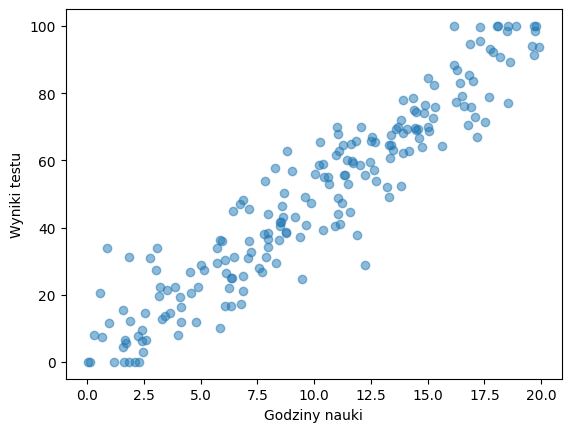

In [104]:
# Generujemy dane do regresji -- czas nauki a wyniki na teście

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generowanie danych syntetycznych
np.random.seed(123)
N = 200  # liczba studentów

hours_studied = np.random.uniform(0, 20, N)
test_scores = 5 * hours_studied + np.random.normal(0, 10, N)  # wynik z szumem
test_scores = np.clip(test_scores, 0, 100)  # zakres wyników 0-100
passed = (test_scores >= 50).astype(int)

# Wykres
plt.scatter(hours_studied, test_scores, alpha=0.5)
plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.show()

Teraz dodajmy podział na **klasy**:
- *zdał* -- dla >= 50 pkt.
- *oblał* -- dla < 50 pkt.

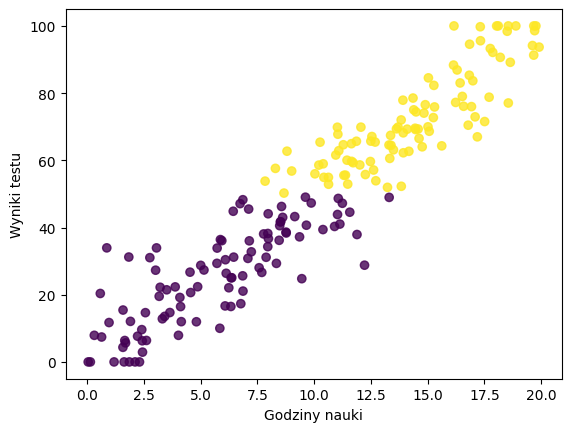

In [105]:
passed = (test_scores >= 50).astype(int)

# Podział danych
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    hours_studied.reshape(-1,1), test_scores, passed, test_size=0.2, random_state=42
)

# Wykres
plt.scatter(hours_studied, test_scores, c=passed, alpha=0.8)
plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.show()

Na tej podstawie możemy zbudować zbiór danych dla naszego dwuzadaniowego modelu.

In [106]:
import torch
from torch.utils.data import Dataset, DataLoader

# Podział danych
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    hours_studied.reshape(-1,1), test_scores, passed,
    test_size=0.2
)

# Dane możemy opakować w klasę StudentDataset dla wygody korzystania
# z treningu grupami (batch)

class StudentDataset(Dataset):
    def __init__(self, X, y_reg, y_cls):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_reg = torch.tensor(y_reg, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Dla każdego X zwracamy wynik regresji oraz klasę
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]


train_ds = StudentDataset(X_train, y_reg_train, y_cls_train)
test_ds = StudentDataset(X_test, y_reg_test, y_cls_test)

# Porcje po 16 elementów
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# Podgląd
for X_batch, y_reg_batch, y_cls_batch in train_loader:
    print(X_batch.shape, y_reg_batch.shape, y_cls_batch.shape)
    for hours, score, cls in zip(X_batch, y_reg_batch, y_cls_batch):
        print(f'{hours = } {score = } {cls = }')
    break

torch.Size([16, 1]) torch.Size([16]) torch.Size([16])
hours = tensor([10.6310]) score = tensor(54.9271) cls = tensor(1.)
hours = tensor([13.3863]) score = tensor(64.4632) cls = tensor(1.)
hours = tensor([11.0877]) score = tensor(62.8652) cls = tensor(1.)
hours = tensor([4.8733]) score = tensor(22.3755) cls = tensor(0.)
hours = tensor([11.3801]) score = tensor(55.5959) cls = tensor(1.)
hours = tensor([10.4002]) score = tensor(58.9589) cls = tensor(1.)
hours = tensor([7.9775]) score = tensor(44.0894) cls = tensor(0.)
hours = tensor([12.6195]) score = tensor(57.1166) cls = tensor(1.)
hours = tensor([6.0824]) score = tensor(16.6652) cls = tensor(0.)
hours = tensor([16.9886]) score = tensor(83.6820) cls = tensor(1.)
hours = tensor([16.8334]) score = tensor(85.3200) cls = tensor(1.)
hours = tensor([2.4351]) score = tensor(6.2857) cls = tensor(0.)
hours = tensor([14.8956]) score = tensor(76.5473) cls = tensor(1.)
hours = tensor([13.9106]) score = tensor(77.9035) cls = tensor(1.)
hours = tenso

Epoch 20, Loss: 95.1098
Epoch 40, Loss: 91.9018
Epoch 60, Loss: 89.7476
Epoch 80, Loss: 88.2207
Epoch 100, Loss: 87.3284

Regresja - MAE: 6.25
Klasyfikacja - dokładność: 0.97


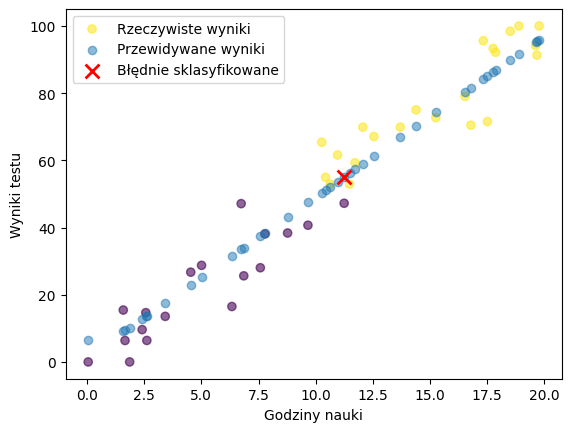

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        backbone_output_size = 10
        # Część wspólna (kręgosłup modelu, ang. backbone)
        self.shared = nn.Sequential(
            nn.Linear(1, backbone_output_size),
            nn.ReLU()
        )
        # Głowice modelu -- po jednej dla zadania.
        # Wejściem głowicy jest wynik części wspólnej

        # Głowica dla regresji
        self.regression = nn.Linear(backbone_output_size, 1)

        # Głowica dla klasyfikacji
        self.classification = nn.Sequential(
            nn.Linear(backbone_output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        shared_out = self.shared(x)  # wynik części wspólnej
        #                           / regresja     \ klasyfikacja
        #                          v                v
        return self.regression(shared_out), self.classification(shared_out)


# Trening
model = SimpleMultiTaskModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Uwaga -- 2 funkcje straty, bo 2 zadania:
reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.BCELoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for X_batch, y_reg_batch, y_cls_batch in train_loader:
        optimizer.zero_grad()

        reg_pred, cls_pred = model(X_batch)

        reg_loss = reg_loss_fn(reg_pred.squeeze(), y_reg_batch)
        cls_loss = cls_loss_fn(cls_pred.squeeze(), y_cls_batch)
        loss = reg_loss + cls_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


# Ewaluacja
model.eval()
with torch.no_grad():
    reg_preds, cls_preds = model(torch.tensor(X_test, dtype=torch.float32))
    reg_preds = reg_preds.squeeze().numpy()
    cls_preds = (cls_preds.squeeze().numpy() > 0.5).astype(int)

# Błąd regresji, tj. MAE (ang. Mean Abs. Error)
reg_mae = np.mean(np.abs(reg_preds - y_reg_test))
# Dokładność klasyfikacji
cls_accuracy = np.mean(cls_preds == y_cls_test)

print(f"\nRegresja - MAE: {reg_mae:.2f}")
print(f"Klasyfikacja - dokładność: {cls_accuracy:.2f}")

misclassified = y_cls_test != cls_preds

# Wizualizacja
plt.scatter(X_test, y_reg_test, c=y_cls_test, label='Rzeczywiste wyniki', alpha=0.6)
plt.scatter(X_test, reg_preds, label='Przewidywane wyniki', alpha=0.5)

plt.scatter(X_test[misclassified], reg_preds[misclassified], c='red', marker='x', s=100,
            label='Błędnie sklasyfikowane', linewidths=2)

plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.legend()
plt.show()


# Zad. 3.

Jako analityk danych edukacyjnych próbujesz jednocześnie przewidzieć wyniki (oceny) uczniów oraz ich aktywność pozalekcyjną. Twój model ma **dwa cele**, bazujące na demograficznych, społecznych i szkolnych atrybutach ucznia:

1. **Zadanie regresji:** Przewidywanie końcowego wyniku egzaminu ucznia (wartość ciągła w zakresie od 0 do 100).  
2. **Zadanie klasyfikacji:** Przewidywanie, czy uczeń uczestniczy w zajęciach pozalekcyjnych (`1`: tak, `0`: nie).

Na podstawie powyższego przykładu wytrenuj model typu MLP rozwiązujący postawiony problem.

Zbiorem danych jest
[UCI Machine Learning Repository - Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance):
  - Zawiera rzeczywiste dane uczniów z dwóch portugalskich szkół.  
  - Cechy obejmują atrybuty demograficzne (wiek, płeć), kontekst społeczny (wielkość rodziny, wykształcenie rodziców, relacje rodzinne), tło akademickie (wcześniejsze oceny, nieobecności) oraz atrybuty behawioralne (udział w zajęciach pozalekcyjnych, spożycie alkoholu).  
  - Zmienne docelowe:  
    - **Końcowa ocena (G3):** Ciągła wartość numeryczna reprezentująca końcowy wynik egzaminu (0-20, skalowana do 0-100).  
    - **Udział w zajęciach pozalekcyjnych:** Wskaźnik binarny (`tak`/`nie`), dostępny bezpośrednio w zbiorze danych.


**Wskazówki**:
- Podziel dane w stosunku `80/20` na zb. treningowy oraz testowy
- Sprawdź model z 1 oraz 2 warstwami ukrytymi oraz liczbą neuronów <= 100 w warstwie
- Liczba epok <= 500
- Czy możemy wpłynąć na wynik treningu, jeżeli wartość straty części regresyjnej przemnożymy, np. przez 10 zmieniając *wagę* tego zadania?


**Dodatkowo**:

Wytrenuj dwa odrębne modele, z których jeden dokonuje klasyfikacji a drugi regresji i porównaj wyniki z pierwotnym modelem.

Czy wyniki wskazują na korelację pomiędzy wynikami w nauce a udziałem w zajęciach pozalekcyjnych?

## Pobranie danych

In [108]:
import pandas as pd
import requests
import zipfile
import io
from sklearn.preprocessing import StandardScaler

def load_data(url, file_name):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open(file_name) as f:
            df = pd.read_csv(f, sep=';')
    return df

# Przetwarzanie wstępne danych:
# - Skaluj ocenę końcową 'G3' do 0-100.
# - Mapuj 'activities' na wartości binarne.
# - Usuń pośrednie oceny i zakoduj pozostałe cechy metodą one-hot.
# - Standaryzuj cechy.
def preprocess_data(df):
    y_reg = df['G3'] * 5
    y_cls = df['activities'].map({'yes': 1, 'no': 0})

    # POPRAWKA: Usuwamy 'activities' z 'X' razem z 'G1', 'G2', 'G3'
    X = df.drop(['G1', 'G2', 'G3', 'activities'], axis=1)

    display("Pierwsze 3 wiersze X (przed kodowaniem):", X.head(3))

    # drop_first=True pomaga uniknąć współliniowości po kodowaniu
    X = pd.get_dummies(X, drop_first=True)
    display('Pierwsze 3 wiersze X (po kodowaniu one-hot):', X.head(3))

    # Zapisujemy liczbę cech po kodowaniu
    input_dim = X.shape[1]
    print(f"\nPoprawna liczba cech wejściowych (INPUT_SIZE): {input_dim}\n")

    X_scaled = StandardScaler().fit_transform(X)

    return X_scaled, y_reg, y_cls, input_dim


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
file_name = 'student-mat.csv'
df = load_data(url, file_name)
X, y_reg, y_cls, INPUT_SIZE = preprocess_data(df)

'Pierwsze 3 wiersze X (przed kodowaniem):'

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10


'Pierwsze 3 wiersze X (po kodowaniu one-hot):'

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,False,True,False,True,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,False,True,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,False,True,False,True,False,True,True,True,True,False



Poprawna liczba cech wejściowych (INPUT_SIZE): 38



In [109]:
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls,
    test_size=0.2,
    random_state=42
)

print(f"Liczba próbek treningowych: {len(X_train)}")
print(f"Liczba próbek testowych: {len(X_test)}")

Liczba próbek treningowych: 316
Liczba próbek testowych: 79


In [110]:
import torch
from torch.utils.data import Dataset, DataLoader

class PerformanceDataset(Dataset):
    def __init__(self, X, y_reg, y_cls):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_reg = torch.tensor(y_reg.values, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls.values, dtype=torch.float32)

    def __len__(self):
        # Zwraca liczbę wszystkich próbek w zbiorze
        return len(self.X)

    def __getitem__(self, idx):
        # zwraca jedną próbkę na podstawie jej indeksu
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]

In [111]:
train_ds = PerformanceDataset(X_train, y_reg_train, y_cls_train)
test_ds = PerformanceDataset(X_test, y_reg_test, y_cls_test)

BATCH_SIZE = 32

# shuffle=True, aby na każdej epoce dane były wymieszane
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [112]:
for X_batch, y_reg_batch, y_cls_batch in train_loader:
    print("Sprawdzenie pierwszej porcji danych:")
    print(f"Kształt X_batch: {X_batch.shape}")
    print(f"Kształt y_reg_batch: {y_reg_batch.shape}")
    print(f"Kształt y_cls_batch: {y_cls_batch.shape}")

    break

Sprawdzenie pierwszej porcji danych:
Kształt X_batch: torch.Size([32, 38])
Kształt y_reg_batch: torch.Size([32])
Kształt y_cls_batch: torch.Size([32])


In [117]:
import torch.nn as nn
import torch.nn.functional as F

# hiperparametry
INPUT_SIZE = 38       # X_batch.shape
HIDDEN_SIZE = 64      # 1 warstwa ukryta, <= 100 neuronów
REG_OUTPUT_SIZE = 1   # Głowica regresji zwraca 1 liczbę
CLS_OUTPUT_SIZE = 1   # Głowica klasyfikacji zwraca 1 liczbę

class MultiTaskStudentModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        # 1. CZĘŚĆ WSPÓLNA (BACKBONE)
        self.shared = nn.Sequential(
            nn.Linear(input_size, HIDDEN_SIZE),
            nn.ReLU()
        )

        # 2. GŁOWICA REGRESJI
        self.regression = nn.Linear(HIDDEN_SIZE, REG_OUTPUT_SIZE)

        # 3. GŁOWICA KLASYFIKACJI
        self.classification = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, CLS_OUTPUT_SIZE),
            nn.Sigmoid()
        )

    def forward(self, x):

        # 1. Przekaż dane przez część wspólną
        shared_out = self.shared(x)

        # 2. Przekaż wynik części wspólnej do obu głowic
        reg_head_output = self.regression(shared_out)
        cls_head_output = self.classification(shared_out)

        return reg_head_output, cls_head_output

In [118]:
# Stwórz instancję modelu
model = MultiTaskStudentModel(INPUT_SIZE)

print(model)

with torch.no_grad():
    reg_pred, cls_pred = model(X_batch)

print(f"\nKształt wyjścia regresji: {reg_pred.shape}")
print(f"Kształt wyjścia klasyfikacji: {cls_pred.shape}")

MultiTaskStudentModel(
  (shared): Sequential(
    (0): Linear(in_features=38, out_features=64, bias=True)
    (1): ReLU()
  )
  (regression): Linear(in_features=64, out_features=1, bias=True)
  (classification): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

Kształt wyjścia regresji: torch.Size([32, 1])
Kształt wyjścia klasyfikacji: torch.Size([32, 1])


In [124]:
import torch.optim as optim

model = MultiTaskStudentModel(INPUT_SIZE)
LEARNING_RATE = 0.01
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.BCELoss()

NUM_EPOCHS = 100

REG_LOSS_WEIGHT = 10.0

print("Rozpoczynam trening...")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_reg_batch, y_cls_batch in train_loader:

        # 1. Wyzeruj gradienty
        optimizer.zero_grad()

        # 2. Forward pass (przepuszczenie danych przez model)
        reg_pred, cls_pred = model(X_batch)

        # 3. Oblicz straty
        reg_loss = reg_loss_fn(reg_pred.squeeze(), y_reg_batch)

        # Strata klasyfikacji
        cls_loss = cls_loss_fn(cls_pred.squeeze(), y_cls_batch)

        # 4. Połącz straty (z uwzględnieniem wagi)
        loss = (REG_LOSS_WEIGHT * reg_loss) + cls_loss

        # 5. Backward pass (oblicz gradienty)
        loss.backward()

        # 6. Aktualizuj wagi
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoka [{epoch+1}/{NUM_EPOCHS}], Strata: {avg_loss:.4f}")

print("Trening zakończony.")

Rozpoczynam trening...
Epoka [20/100], Strata: 2080.9904
Epoka [40/100], Strata: 1204.8778
Epoka [60/100], Strata: 748.6588
Epoka [80/100], Strata: 470.5968
Epoka [100/100], Strata: 282.9966
Trening zakończony.


In [125]:
import numpy as np

model.eval()

# Tensory testowe
X_test_tensor = test_ds.X
y_reg_test_tensor = test_ds.y_reg
y_cls_test_tensor = test_ds.y_cls

with torch.no_grad():
    # Predykcja testowa
    reg_preds_tensor, cls_preds_tensor = model(X_test_tensor)

# Konwersja wyników
reg_preds_np = reg_preds_tensor.squeeze().numpy()

cls_preds_np = (cls_preds_tensor.squeeze().numpy() > 0.5).astype(int)

# Etykiety testowe
y_reg_test_np = y_reg_test_tensor.numpy()
y_cls_test_np = y_cls_test_tensor.numpy()


# Obliczenie matryk

# Mean Absolute Error
# np.mean(np.abs(przewidziane - rzeczywiste))
reg_mae = np.mean(np.abs(reg_preds_np - y_reg_test_np))

# Dokładność (accuracy) dla klasyfikacji
# np.mean(przewidziane == rzeczywiste)
cls_accuracy = np.mean(cls_preds_np == y_cls_test_np)

print(f"\n--- Ewaluacja na zbiorze testowym ---")
print(f"Zadanie Regresji (Wynik 0-100):")
print(f"  Średni błąd absolutny (MAE): {reg_mae:.2f} punktów")
print(f"\nZadanie Klasyfikacji (Aktywność 0/1):")
print(f"  Dokładność (Accuracy): {cls_accuracy * 100:.2f} %")


--- Ewaluacja na zbiorze testowym ---
Zadanie Regresji (Wynik 0-100):
  Średni błąd absolutny (MAE): 20.31 punktów

Zadanie Klasyfikacji (Aktywność 0/1):
  Dokładność (Accuracy): 46.84 %


## Wyniki:
0. Bazowo (REG_LOSS_WEIGHT = 1.0)
- Zadanie Regresji (Wynik 0-100) - Średni błąd absolutny (MAE): 21.50 punktów

- Zadanie Klasyfikacji (Aktywność 0/1) - Dokładność (Accuracy): 53.16 %


1. Modyfikacja 1 (REG_LOSS_WEIGHT = 10.0)
- Zadanie Regresji (Wynik 0-100) - Średni błąd absolutny (MAE): 20.31 punktów

- Zadanie Klasyfikacji (Aktywność 0/1) - Dokładność (Accuracy): 46.84 %

## Wniosek
Ponieważ reg_loss ma 10-krotnie większy wpływ gradienty będą silniej oddziaływać na wagi modelu. Zauważono poprawę w metryce regresji (niższy średni błąd absolutny), ale dokładność się zmiejeszyła. Model zaczął traktować zadanie klasyfikacji jako drugorzędne. Może to być przydatne zachowanie, gdy jedno z zadań jest dla nas ważniejsze.


In [126]:
# Model 2: Tylko Regresja
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, REG_OUTPUT_SIZE) # Bezpośrednio do głowicy
        )

    def forward(self, x):
        return self.model(x)


# Model 3: Tylko Klasyfikacja
class ClassificationModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, CLS_OUTPUT_SIZE),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.BCELoss()

In [131]:
from sklearn.metrics import mean_absolute_error, accuracy_score

print("\n=== EKSPERYMENT 1: Model Wielozadaniowy (MTL) ===")
# Użyjemy wagi 1.0 dla sprawiedliwego porównania
REG_LOSS_WEIGHT = 1.0

model_mtl = MultiTaskStudentModel(INPUT_SIZE)
optimizer_mtl = optim.Adam(model_mtl.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model_mtl.train()
    for X_batch, y_reg_batch, y_cls_batch in train_loader:
        optimizer_mtl.zero_grad()
        reg_pred, cls_pred = model_mtl(X_batch)

        reg_loss = reg_loss_fn(reg_pred.squeeze(), y_reg_batch)
        cls_loss = cls_loss_fn(cls_pred.squeeze(), y_cls_batch)

        loss = (REG_LOSS_WEIGHT * reg_loss) + cls_loss
        loss.backward()
        optimizer_mtl.step()

print("Trening MTL zakończony.")

# Ewaluacja MTL
model_mtl.eval()
with torch.no_grad():
    reg_preds_tensor, cls_preds_tensor = model_mtl(test_ds.X)

reg_preds_np = reg_preds_tensor.squeeze().numpy()
cls_preds_np = (cls_preds_tensor.squeeze().numpy() > 0.5).astype(int)

y_reg_test_np = test_ds.y_reg.numpy()
y_cls_test_np = test_ds.y_cls.numpy()

mae_mtl = mean_absolute_error(y_reg_test_np, reg_preds_np)
acc_mtl = accuracy_score(y_cls_test_np, cls_preds_np)

print(f"  [MTL] MAE Regresji: {mae_mtl:.2f} punktów")
print(f"  [MTL] Dokładność Klasyfikacji: {acc_mtl * 100:.2f}")


=== EKSPERYMENT 1: Model Wielozadaniowy (MTL) ===
Trening MTL zakończony.
  [MTL] MAE Regresji: 20.29 punktów
  [MTL] Dokładność Klasyfikacji: 46.84


In [132]:
print("\n=== EKSPERYMENT 2: Oddzielny Model (Tylko Regresja) ===")
model_reg = RegressionModel(INPUT_SIZE)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model_reg.train()
    # Ignorujemy y_cls_batch (podkreślenie _)
    for X_batch, y_reg_batch, _ in train_loader:
        optimizer_reg.zero_grad()
        reg_pred = model_reg(X_batch)

        loss = reg_loss_fn(reg_pred.squeeze(), y_reg_batch)
        loss.backward()
        optimizer_reg.step()

print("Trening Regresji zakończony.")

# Ewaluacja Regresji
model_reg.eval()
with torch.no_grad():
    reg_preds_tensor = model_reg(test_ds.X)

reg_preds_np = reg_preds_tensor.squeeze().numpy()
mae_separate = mean_absolute_error(y_reg_test_np, reg_preds_np)

print(f"  [Oddzielny] MAE Regresji: {mae_separate:.2f} punktów")


=== EKSPERYMENT 2: Oddzielny Model (Tylko Regresja) ===
Trening Regresji zakończony.
  [Oddzielny] MAE Regresji: 20.31 punktów


In [133]:
print("\n=== EKSPERYMENT 3: Oddzielny Model (Tylko Klasyfikacja) ===")
model_cls = ClassificationModel(INPUT_SIZE)
optimizer_cls = optim.Adam(model_cls.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model_cls.train()
    # Ignorujemy y_reg_batch (podkreślenie _)
    for X_batch, _, y_cls_batch in train_loader:
        optimizer_cls.zero_grad()
        cls_pred = model_cls(X_batch)

        loss = cls_loss_fn(cls_pred.squeeze(), y_cls_batch)
        loss.backward()
        optimizer_cls.step()

print("Trening Klasyfikacji zakończony.")

# Ewaluacja Klasyfikacji
model_cls.eval()
with torch.no_grad():
    cls_preds_tensor = model_cls(test_ds.X)

cls_preds_np = (cls_preds_tensor.squeeze().numpy() > 0.5).astype(int)
acc_separate = accuracy_score(y_cls_test_np, cls_preds_np)

print(f"  [Oddzielny] Dokładność Klasyfikacji: {acc_separate * 100:.2f} %")


=== EKSPERYMENT 3: Oddzielny Model (Tylko Klasyfikacja) ===
Trening Klasyfikacji zakończony.
  [Oddzielny] Dokładność Klasyfikacji: 40.51 %


## Wniosek

Porównując wyniki modelu wielozadaniowego z wynikami modeli trenowanych oddzielnie możemy zauważyć niewielkie różnice w wynikach. Wskazuje to na brak wyraźnej przewagi modelu wielozadaniowego. Oznacza to, że w przypadku tej prostej architektury model nie był w stanie znaleźć silnych, wspólnych wzorców, które pomogłyby obu zadaniom jednocześnie.